In [ ]:
# 1. --- IMPORTS ---
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Vision Libraries
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# 2. --- SETUP PATHS AND CONFIGURATION ---
BASE_PATH = '/kaggle/input/'
TRAIN_CSV = os.path.join(BASE_PATH, 'train_1.csv')
VAL_CSV = os.path.join(BASE_PATH, 'valid.csv')
TRAIN_DIR = os.path.join(BASE_PATH, 'train_images/train_images')
VAL_DIR = os.path.join(BASE_PATH, 'val_images/val_images')

# Training Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 20
MIXUP_ALPHA = 1.0 # Alpha for Mixup, 1.0 is a good default


In [ ]:
# 3. --- AUGMENTATIONS ---
# A robust set of augmentations for this task
train_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.4), # Enhance local contrast
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
# 4. --- PYTORCH DATASET CLASS ---
class DRDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index]['id_code'] + '.png'
        label = self.df.iloc[index]['diagnosis']
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label


In [ ]:
# 5. --- HYBRID MODEL DEFINITION ---
class HybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridModel, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0)

        self.fusion = nn.Sequential(
            nn.Linear(self.efficientnet.num_features + self.resnet.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feat1 = self.efficientnet(x)
        feat2 = self.resnet(x)
        combined = torch.cat((feat1, feat2), dim=1)
        out = self.fusion(combined)
        return out


In [ ]:
# 6. --- HELPER FUNCTION FOR MIXUP LOSS ---
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
# 7. --- MAIN SCRIPT EXECUTION ---
if __name__ == '__main__':
    # Load dataframes
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)

    # Create datasets and dataloaders
    train_dataset = DRDataset(train_df, TRAIN_DIR, transform=train_transform)
    val_dataset = DRDataset(val_df, VAL_DIR, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model, loss, and optimizer
    model = HybridModel(num_classes=5).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
print("--- Starting Training ---")
print(f"Device: {DEVICE}")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}")
print(f"Using Mixup with alpha = {MIXUP_ALPHA}")
for epoch in range(EPOCHS):
    model.train()
    for (images, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Mixup implementation
        lam = np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA)
        rand_index = torch.randperm(images.size()[0])
        images_b = images[rand_index]
        labels_b = labels[rand_index]
        mixed_images = lam * images + (1 - lam) * images_b

        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = mixup_criterion(criterion, outputs, labels, labels_b, lam)
        loss.backward()
        optimizer.step()


--- Starting Training ---
Device: cuda
Epochs: 20, Batch Size: 32, Learning Rate: 0.0001
Using Mixup with alpha = 1.0


Epoch 20/20: 100%|██████████| 92/92 [02:38<00:00,  1.73s/it]



--- Validation Metrics for Epoch 20 ---
                  precision    recall  f1-score   support

           No DR       0.98      0.99      0.99       172
            Mild       0.72      0.65      0.68        40
        Moderate       0.76      0.90      0.83       104
          Severe       0.64      0.41      0.50        22
Proliferative DR       0.70      0.50      0.58        28

        accuracy                           0.86       366
       macro avg       0.76      0.69      0.72       366
    weighted avg       0.85      0.86      0.85       366



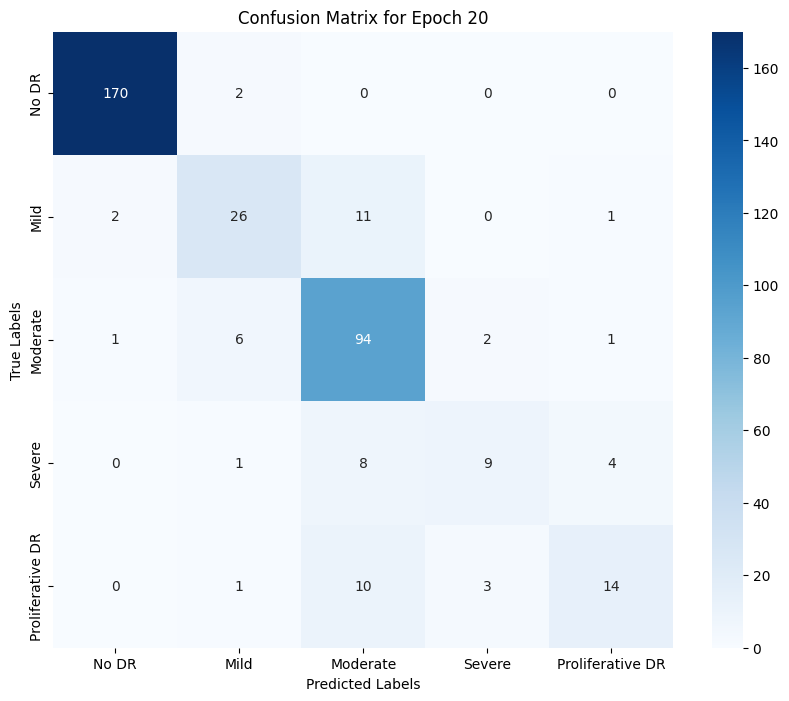

--- Training complete. ---


In [ ]:
# --- Validation Phase ---
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Reporting ---
print(f"\n--- Validation Metrics for Epoch {epoch+1} ---")
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for Epoch {epoch+1}')
plt.show()

print("--- Training complete. ---")
